In [5]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import ConcatDataset, DataLoader
from torchmetrics import AUROC  # additional dependency
from torchvision.datasets import CIFAR10
from tqdm.notebook import tqdm

from oodtk import NegativeEnergy, Softmax, ODIN, MCD, Mahalanobis
from oodtk.dataset.img import Textures, CIFAR10C, LSUNCrop, LSUNResize, TinyImageNetResize, TinyImageNetCrop
from oodtk.model import WideResNet
from oodtk.utils import is_unknown
from oodtk.metrics import OODMetrics
from oodtk.transforms import ToRGB


In [2]:
torch.manual_seed(123)

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

trans = tvt.Compose([ToRGB(), tvt.Resize((32,32)), tvt.ToTensor(), tvt.Normalize(mean, std)])

# setup data
dataset_train = CIFAR10(root="data", train=True, download=True, transform=trans)
dataset_in_test = CIFAR10(root="data", train=False, transform=trans)
dataset_out_test1 = Textures(root="data", download=True, transform=trans)
dataset_out_test2 = LSUNCrop(root="data", download=True, transform=trans)
dataset_out_test3 = LSUNResize(root="data", download=True, transform=trans)
dataset_out_test4 = TinyImageNetResize(root="data", download=True, transform=trans)
dataset_out_test5 = TinyImageNetCrop(root="data", download=True, transform=trans)
dataset_test = dataset_in_test + dataset_out_test1 + dataset_out_test2 + dataset_out_test3 + dataset_out_test4 + dataset_out_test5
train_loader = DataLoader(dataset_train, batch_size=128, num_workers=20)
test_loader = DataLoader(dataset_test, batch_size=128, num_workers=20)

Files already downloaded and verified


/home/ki/.local/share/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model = WideResNet.from_pretrained("oe-cifar10-tune", num_classes=10).eval().cuda()
method = Softmax(model).cuda()
metrics = OODMetrics()

with torch.no_grad():
    for n, batch in enumerate(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

In [ ]:
model = WideResNet.from_pretrained("er-cifar10-tune", num_classes=10).eval().cuda()
energy = NegativeEnergy(model)
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        metrics.update(energy.predict(x), y)

print(metrics.compute())
metrics.reset()

In [ ]:
model = WideResNet.from_pretrained("cifar10-pt", num_classes=10).eval().cuda()
method = Softmax(model)
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

In [ ]:
model = WideResNet.from_pretrained("cifar10-pt", num_classes=10).eval().cuda()
method = NegativeEnergy(model)
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

In [ ]:
model = WideResNet.from_pretrained("cifar10-pt", num_classes=10).eval().cuda()
method = ODIN(model, eps=0.002, norm_std=std)
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

In [ ]:
model = WideResNet.from_pretrained("cifar10-pt", num_classes=10).eval().cuda()
method = MCD(model)
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

In [3]:
model = WideResNet.from_pretrained("oe-cifar10-tune", num_classes=10).eval().cuda()
method = MCD(model)
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/435 [00:00<?, ?it/s]

/home/ki/.local/share/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'AUROC': 0.7504278421401978, 'AUPR-IN': 0.8881632089614868, 'AUPR-OUT': 0.5372937321662903, 'ACC95TPR': 0.8582494854927063, 'FPR95TPR': 0.5605000257492065}


In [4]:

model = WideResNet.from_pretrained("oe-cifar10-tune", num_classes=10).eval().cuda()
method = NegativeEnergy(model)
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/435 [00:00<?, ?it/s]

/home/ki/.local/share/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'AUROC': 0.9881040453910828, 'AUPR-IN': 0.9970607161521912, 'AUPR-OUT': 0.9618299603462219, 'ACC95TPR': 0.9485801458358765, 'FPR95TPR': 0.05790000036358833}


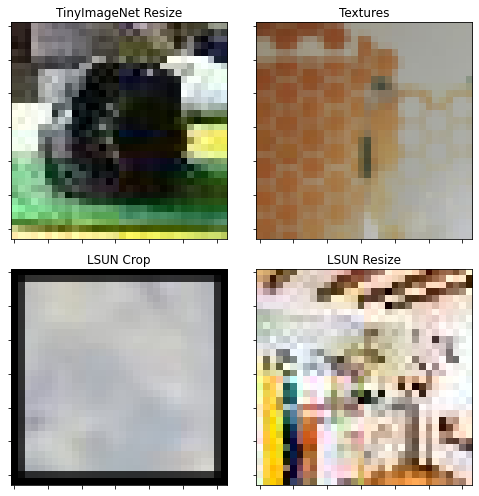

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
trans = tvt.Compose([
    ToRGB(),
    tvt.Resize(32),
    tvt.CenterCrop(32),
    tvt.ToTensor()
    ])

dataset_1 = CIFAR10(root="data", train=False, transform=trans)
dataset_2 = Textures(root="data", download=True, transform=trans)
dataset_3 = LSUNCrop(root="data", download=True, transform=trans)
dataset_4 = LSUNResize(root="data", download=True, transform=trans)
dataset_5 = TinyImageNetResize(root="data", download=True, transform=trans)

a = dataset_5[4][0]
b = dataset_2[0][0]
c = dataset_3[2][0]
d = dataset_4[7][0]

fix, ax = plt.subplots(2,2, figsize=(7,7))
ax = ax.flatten()

ax[0].imshow(to_pil_image(a))
ax[0].axes.yaxis.set_ticklabels([])
ax[0].axes.xaxis.set_ticklabels([])
ax[0].set_title("TinyImageNet Resize")

ax[1].imshow(to_pil_image(b))
ax[1].axes.yaxis.set_ticklabels([])
ax[1].axes.xaxis.set_ticklabels([])
ax[1].set_title("Textures")

ax[2].imshow(to_pil_image(c))
ax[2].axes.yaxis.set_ticklabels([])
ax[2].axes.xaxis.set_ticklabels([])
ax[2].set_title("LSUN Crop")

ax[3].imshow(to_pil_image(d))
ax[3].axes.yaxis.set_ticklabels([])
ax[3].axes.xaxis.set_ticklabels([])
ax[3].set_title("LSUN Resize")

# # disabling xticks by Setting xticks to an empty list
# plt.xticks([])
#
# # disabling yticks by setting yticks to an empty list
# plt.yticks([])

plt.tight_layout()
plt.savefig("/home/ki/examples-small.png", dpi=300)